# Numerical Simulation of a Galactic Dynamo

Mean field induction equation is given by $$\frac{\partial \overline{\boldsymbol{B}}}{\partial t}=\nabla \times(\overline{\boldsymbol{V}} \times \overline{\boldsymbol{B}}+\mathcal{E}-\eta \nabla \times \overline{\boldsymbol{B}})$$. Here $\overline{B}$, $\overline{V}$, $\mathcal{E}$($\equiv \overline{\boldsymbol{v} \times \boldsymbol{b}}$ ) and $\eta$ are representation ofmean magnetic field, mean velocity field, mean electromotive force and magnetic diffusivity, respectively.



 If we assume $\mathcal{E}=\alpha \overline{\boldsymbol{B}}-\eta_{\mathrm{t}} \boldsymbol{\nabla} \times \overline{\boldsymbol{B}}$ and to solve the equations in cylindrical coordinates (r, $\phi$, $z$), we make the approximations by ignoring the term $(\overline{\boldsymbol{V}} \times \overline{\boldsymbol{B}})$ and $\alpha \overline{\boldsymbol{B}}$ terms.


Therefore, we have
$$\frac{\partial \overline{\boldsymbol{B}}}{\partial t}=-\nabla \times \left( \eta_T (\nabla \times \overline{\boldsymbol{B}})\right)$$
If we assume $\eta_T$ is a constant in time. The RHS of above eqaution simplifies to $\nabla \times(\nabla \times \overline{\mathbf{B}})$. After which we can apply the vector theorem $$\nabla \times(\nabla \times \overline{\mathbf{B}})=\nabla(\nabla \cdot \overline{\mathbf{B}})-\nabla^2 \overline{\mathbf{B}}$$


Therefore, the final expression becomes
$$\frac{\partial \overline{\boldsymbol{B}}}{\partial t}=\eta_T \nabla^2 \overline{\mathbf{B}}$$


This is the diffusion equation and can be solved using a variety of methods. Crank-Nicolson method is implemented in this project. 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import random

In [16]:

def initial_condition(x,amp=1):
    return amp * np.sin(np.pi * (x + 1) / 2)
def initial_condition_multiple_modes(x):
    num_modes = random.randint(1, 10)  #as num modes>1 is required
    amplitudes = [random.uniform(0, 1) for k in range(num_modes)]  
    frequencies = [random.uniform(0.1, 10) for p in range(num_modes)] 
    print(f"The eigen modes are {frequencies}.")
    amplitude_sum_sq = sum(a ** 2 for a in amplitudes)
    normalized_amplitudes = [a / np.sqrt(amplitude_sum_sq) for a in amplitudes]#normalized
    result = np.zeros_like(x)
    for amp, freq in zip(normalized_amplitudes, frequencies):
        result += amp * np.sin(2 * np.pi * freq * x)
    return result

def initial_condition_freq(x, freq=2):    
        return np.sin(np.pi * freq * (x + 1) / 2)
def boundary_conditions(B):
    B[0] = 0
    B[-1] = 0
def create_A(r, Nx):
    A = np.zeros((Nx - 1, Nx - 1))
    for i in range(Nx - 1):
        A[i, i] = 1 + 2 * r
        if i > 0:
            A[i, i - 1] = -r
        if i < Nx - 2:
            A[i, i + 1] = -r
    return A
def create_B_matrix(r, Nx):
    B_matrix = np.zeros((Nx - 1, Nx - 1))
    for i in range(Nx - 1):
        B_matrix[i, i] = 1 - 2 * r
        if i > 0:
            B_matrix[i, i - 1] = r
        if i < Nx - 2:
            B_matrix[i, i + 1] = r
    return B_matrix
def crank_nicolson_magnetic_diffusion(x,t,eta, Nx, Nt, L, T,initial,boundary):
    dx = L / Nx
    dt = T / Nt
    r = eta * dt / (2 * dx**2)
    B = np.zeros((Nx+1, Nt+1))
    B[:, 0] = initial(x)
    A =create_A(r,Nx) 
    B_matrix = create_B_matrix(r,Nx)
    for j in range(Nt):
        boundary(B[:, j])
        B[1:-1, j+1] = np.linalg.solve(A, np.dot(B_matrix, B[1:-1, j]))
    return B

def calculate_B_i(eta,Nx,Nt,L,T,method=crank_nicolson_magnetic_diffusion,initial=initial_condition,boundary=boundary_conditions,show_graph=1):
    # Grid
    x = np.linspace(-1, 1, Nx+1)  # Normalized spatial grid
    t = np.linspace(0, T, Nt+1)    # Time grid
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    # Solve magnetic field diffusion equation using Crank-Nicolson method
    magnetic_field = method(x,t,eta, Nx, Nt, L, T,initial,boundary)
    if show_graph==1:
        # Contour 
        plt.figure(figsize=(10, 6))
        levels = np.linspace(np.min(magnetic_field), np.max(magnetic_field), 20)
        plt.contourf(x, t, magnetic_field.T, levels=levels, cmap='plasma')
        cbar = plt.colorbar(label='Magnetic Field')
        cbar.set_label('Magnetic Field', rotation=270, labelpad=15)
        plt.show()
    return magnetic_field
def decay_B(B,show_graph=1):
    middle_index = len(B) // 2
    thirds=len(B)//3
    B_middle = B[middle_index, :]
    B_thirds = B[thirds, :]
    def exponential_func(t, B0, gamma):
        return B0 * np.exp(gamma * t)
    t_fit = np.linspace(0, T, Nt+1)  
    popt, pcov = curve_fit(exponential_func, t_fit, B_middle)#popt=[B0,gamma]
    popt1, pcov1 = curve_fit(exponential_func, t_fit, B_thirds)
    print("Gamma from z=0:", popt[1])
    print("Gamma from z=-h/3:", popt1[1])
    if show_graph:
        log_B = np.log(B_middle)
        log_B1 = np.log(B_thirds)
        plt.plot(t_fit,log_B,label=f"at z=0,$\gamma$={popt[1]:.5f}")
        plt.plot(t_fit,log_B1,label=f"at z=-h/3,$\gamma$={popt1[1]:.5f}")
        plt.ylabel("log B")
        plt.xlabel("T")
        plt.title("log B vs T")
        plt.grid()
        plt.legend()
        plt.show()
    return(popt[1])
def get_pitch(MeanBR,MeanBPhi):
    pitchvalues=[]
    for i in range(0,len(MeanBR)):
        pitchvalues.append(math.atan(MeanBR[i]/MeanBPhi[i]))
    return pitchvalues
def get_mean_field_B(B_i):
    meanB_t=[]
    for i in range(0,len(B_i)):
        meanB_t.append(np.mean(B_i[:,i]))
    return meanB_t

def plot_all(eta,Nx,Nt,L,T,magnetic_field=calculate_B_i,method=crank_nicolson_magnetic_diffusion,initial=initial_condition,boundary=boundary_conditions,show_graph=1,show_decay=1):
    B_r=magnetic_field(eta,Nx,Nt,L,T,method,initial,boundary,show_graph)
    B_phi=magnetic_field(eta,Nx,Nt,L,T,method,initial,boundary,0)
    gamma=decay_B(B_r,show_graph)
    print(f"Decay($gamma$):{gamma}.")
    pitch=np.mean(get_pitch(get_mean_field_B(B_r),get_mean_field_B(B_phi)))
    print(f"Pitch angle {pitch} which is {pitch/np.pi}\u03C0 .")
    return B_r


In [14]:
# Parameters
eta = 1e-2   # Magnetic diffusivity
L = 1.0      # Length of the domain
T = 5.0      # Total time
Nx = 200   # Number of spatial grid points
Nt = 1000    # Number of time steps

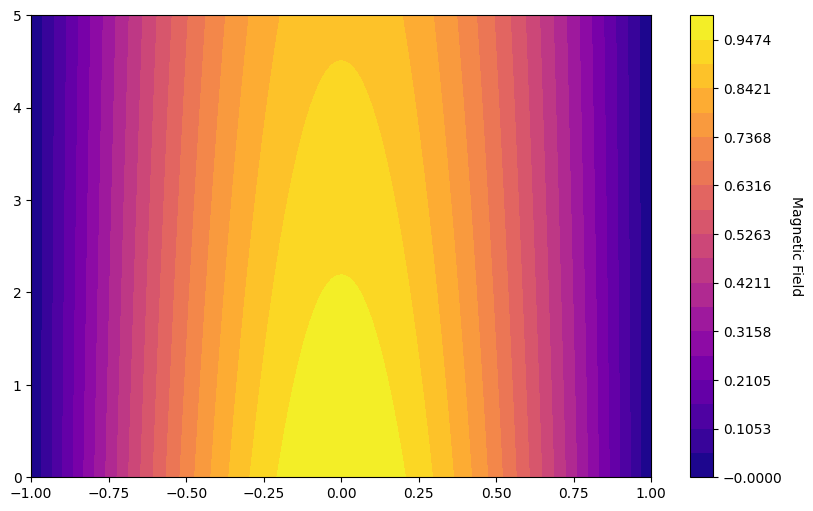

Gamma from z=0: -0.024673504044971598
Gamma from z=-h/3: -0.024673510394166712


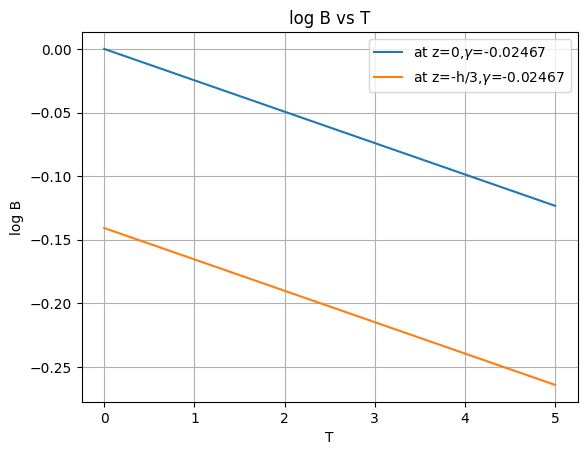

Decay ($\gamma$): -0.024673504044971598.
Pitch angle: 0.7853981633974483 which is 0.25π .


In [15]:
def rk4_magnetic_diffusion(x, t, eta, Nx, Nt, L, T, initial, boundary):
    dx = L / Nx
    dt = T / Nt
    B = np.zeros((Nx + 1, Nt + 1))
    B[:, 0] = initial(x)
    for j in range(Nt):
        boundary(B[:, j])
        k1 = dt * magnetic_diffusion_equation(x, B[:, j], eta, Nx)
        k2 = dt * magnetic_diffusion_equation(x, B[:, j] + 0.5 * k1, eta, Nx)
        k3 = dt * magnetic_diffusion_equation(x, B[:, j] + 0.5 * k2, eta, Nx)
        k4 = dt * magnetic_diffusion_equation(x, B[:, j] + k3, eta, Nx)
        B[:, j + 1] = B[:, j] + (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    return B

def magnetic_diffusion_equation(x, B, eta, Nx):
    dx = x[1] - x[0]
    d2B_dx2 = np.zeros_like(B)
    for i in range(1, Nx):
        d2B_dx2[i] = (B[i - 1] - 2 * B[i] + B[i + 1]) / dx ** 2
    d2B_dx2[0] = d2B_dx2[1]  # Boundary conditions
    d2B_dx2[-1] = d2B_dx2[-2]  # Boundary conditions
    return eta * d2B_dx2
def plot_all_2(eta, Nx, Nt, L, T, magnetic_field=calculate_B_i, method=rk4_magnetic_diffusion, initial=initial_condition, boundary=boundary_conditions, show_graph=1, show_decay=1):
    B_r = magnetic_field(eta, Nx, Nt, L, T, method, initial, boundary, show_graph)
    B_phi = magnetic_field(eta, Nx, Nt, L, T, method, initial, boundary, 0)
    gamma = decay_B(B_r, show_decay)
    print(f"Decay ($\gamma$): {gamma}.")
    pitch = np.mean(get_pitch(get_mean_field_B(B_r), get_mean_field_B(B_phi)))
    print(f"Pitch angle: {pitch} which is {pitch / np.pi}π .")
    return B_r
B_r = plot_all_2(eta, Nx, Nt, L, T,calculate_B_i, rk4_magnetic_diffusion)
